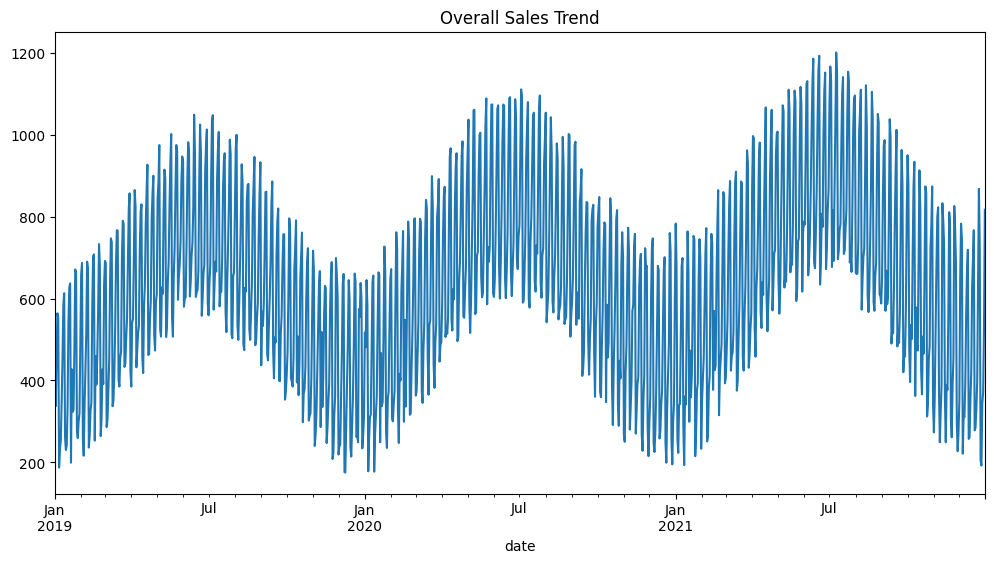

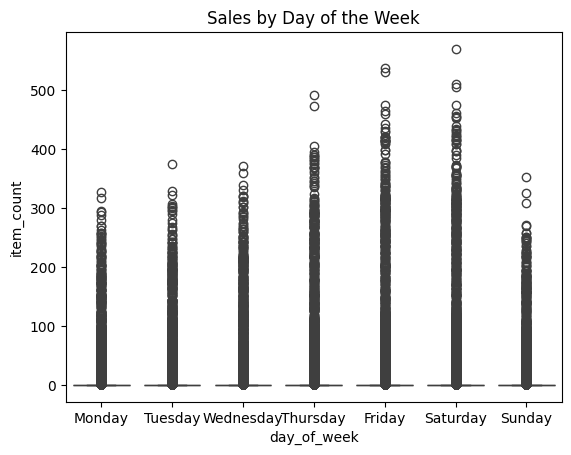

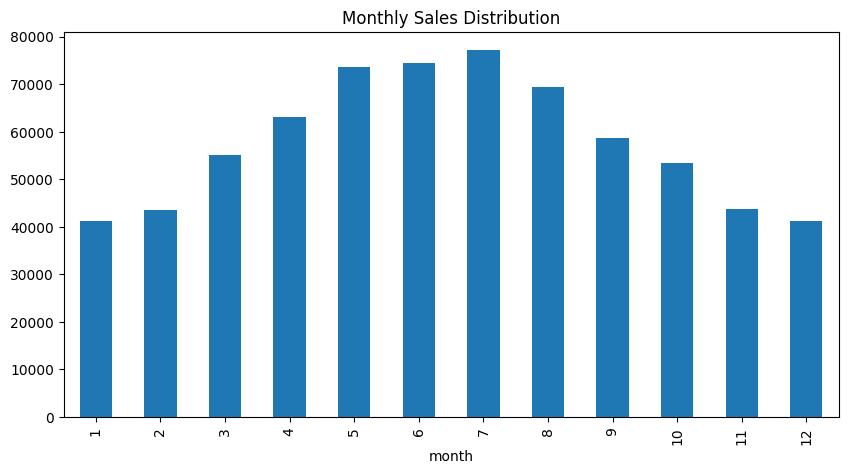

Most Popular Items:
item_name
Bob's Diner       687527.0
Surfs Up            1803.0
Sweet Shack         1736.0
Corner Cafe         1310.0
Beachfront Bar      1305.0
Fou Cher            1106.0
Name: item_count, dtype: float64
Store with highest sales: Strawberry Smoothy
Linear Regression RMSE: 237.04
Random Forest RMSE: 236.56
XGBoost RMSE: 236.58


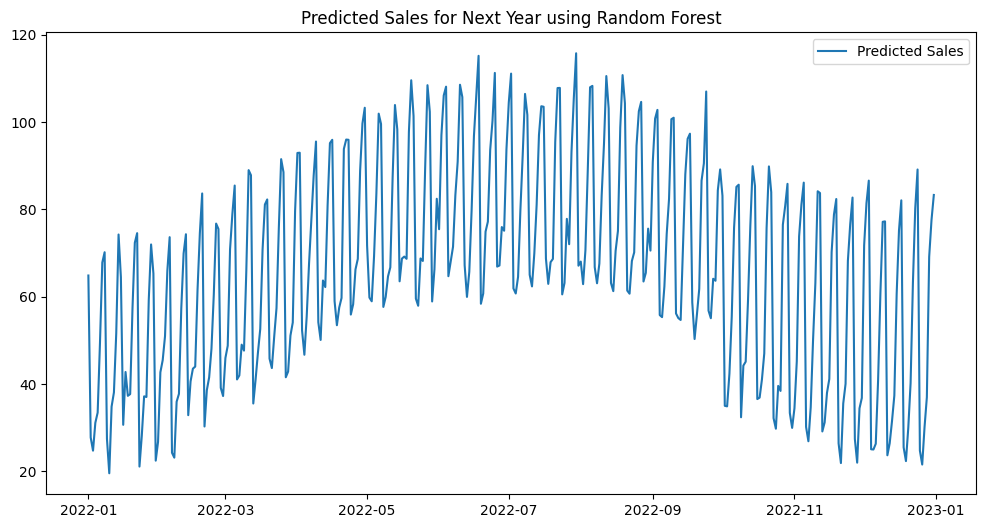

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Import Datasets
df_sales = pd.read_csv("/content/sales.csv")  # Contains date, store_id, item_id, item_count
df_items = pd.read_csv("/content/items.csv")  # Contains item_id, item_name, price, kcal
df_stores = pd.read_csv("/content/resturants.csv")  # Contains store_id, store_name
df_stores.rename(columns={'id': 'store_id'}, inplace=True)
df_items.rename(columns={'id': 'item_id'}, inplace=True)


# Step 2: Merge Datasets
df = df_sales.merge(df_items, on="item_id").merge(df_stores, on="store_id")
df.rename(columns={'name_y': 'item_name',"name_x":"store_name"}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Step 3: Exploratory Data Analysis
plt.figure(figsize=(12, 6))
df.groupby("date")["item_count"].sum().plot()
plt.title("Overall Sales Trend")
plt.show()

# Sales by Day of the Week
df['day_of_week'] = df['date'].dt.day_name()
sns.boxplot(x='day_of_week', y='item_count', data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Sales by Day of the Week")
plt.show()

# Sales Trends by Month
df['month'] = df['date'].dt.month
df.groupby("month")["item_count"].sum().plot(kind="bar", figsize=(10, 5))
plt.title("Monthly Sales Distribution")
plt.show()

# Step 4: Store and Item Analysis
popular_items = df.groupby("item_name")["item_count"].sum().sort_values(ascending=False)
print("Most Popular Items:")
print(popular_items.head(10))

highest_sales_store = df.groupby("store_name")["item_count"].sum().idxmax()
print(f"Store with highest sales: {highest_sales_store}")

# Step 5: Feature Engineering for Forecasting
df['year'] = df['date'].dt.year
df['day_of_month'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['total_sales'] = df['item_count'] * df['price']

# Step 6: Train-Test Split (Last 6 months as test set)
train_df = df[df['date'] < df['date'].max() - pd.DateOffset(months=6)]
test_df = df[df['date'] >= df['date'].max() - pd.DateOffset(months=6)]

features = ["month", "day_of_week", "year", "day_of_month", "quarter"]

ohe = OneHotEncoder(handle_unknown='ignore')
ohe_features = ohe.fit_transform(train_df[['day_of_week']]).toarray()
X_train = np.hstack((train_df[features].drop(columns=['day_of_week']).values, ohe_features))
X_test = np.hstack((test_df[features].drop(columns=['day_of_week']).values, ohe.transform(test_df[['day_of_week']]).toarray()))

y_train = train_df["total_sales"].values
y_test = test_df["total_sales"].values

# Step 7: Model Training & Evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

rmse_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores[name] = rmse
    print(f"{name} RMSE: {rmse:.2f}")

# Step 8: Forecast Next Year Using Best Model
best_model_name = min(rmse_scores, key=rmse_scores.get)
best_model = models[best_model_name]

future_dates = pd.date_range(start=df['date'].max() + pd.DateOffset(1), periods=365, freq='D')
future_df = pd.DataFrame({"date": future_dates})
future_df['month'] = future_df['date'].dt.month
future_df['day_of_week'] = future_df['date'].dt.day_name()
future_df['year'] = future_df['date'].dt.year
future_df['day_of_month'] = future_df['date'].dt.day
future_df['quarter'] = future_df['date'].dt.quarter

ohe_features_future = ohe.transform(future_df[['day_of_week']]).toarray()
X_future = np.hstack((future_df[features].drop(columns=['day_of_week']).values, ohe_features_future))

future_df['predicted_sales'] = best_model.predict(X_future)
plt.figure(figsize=(12, 6))
plt.plot(future_df['date'], future_df['predicted_sales'], label="Predicted Sales")
plt.title(f"Predicted Sales for Next Year using {best_model_name}")
plt.legend()
plt.show()
